In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional
import torch.utils.data
plt.style.use('ggplot')

%matplotlib inline

In [2]:
# define T, mu, sigma
T = 100
mu = 0
sigma = 1

# define the noise schedule
# alpha_t = \prod_{i \le t} (1 - \beta_i)
beta_t = (0.1 - 0.0001) * (np.linspace(1, T, T) - 1) / (T - 1) + 0.0001
alpha_t = np.zeros(T)
for i in range(len(beta_t)):
    if i == 0:
        alpha_t[i] = (1 - beta_t[i])
    else:
        alpha_t[i] = (1 - beta_t[i]) * alpha_t[i - 1]


In [3]:
# deifne the number of samples
n = 5000
# n = 500

# exogenous nodes U_1 ~ N(mu, sigma)
u1 = np.random.normal(mu, sigma, n)
u2 = np.random.normal(mu, sigma, n)
u3 = np.random.normal(mu, sigma, n)
uz = np.random.normal(mu, sigma, n)

# define the structual equation 
# X_i = f_i(X_{pa_i}) + U_i
def create_z(uz):
    return uz + 2

def create_x1(z, u1):
    return z + u1 + 2

def create_x2(z, u2):
    return z ** 2 + u2

def create_x3(x1, x2, u3):
    return x1 ** 2 - x1 * x2 + u3

# endogenous nodes
z = create_z(uz)
x1 = create_x1(z, u1)
x2 = create_x2(z, u2)
x3 = create_x3(x1, x2, u3)

# intervened nodes
x2_do_0 = 0
x2_do_1 = 1 
x2_do_5 = 5
x2_do_10 = 10
x3_do_0 = create_x3(x1, x2_do_0, u3)
x3_do_1 = create_x3(x1, x2_do_1, u3)
x3_do_5 = create_x3(x1, x2_do_5, u3)
x3_do_10 = create_x3(x1, x2_do_10, u3)

# calcualte the mean and standard deviation of endogenous nodes
mean_z = np.mean(z)
std_z = np.std(z)
mean_x1 = np.mean(x1)
std_x1 = np.std(x1)
mean_x2 = np.mean(x2)
std_x2 = np.std(x2)
mean_x3 = np.mean(x3)
std_x3 = np.std(x3)

# # define the function to normalize 
# def normalize_z(x):
#     return (x - mean_z) / std_z

# def normalize_x1(x):
#     return (x - mean_x1) / std_x1

# def normalize_x2(x):
#     return (x - mean_x2) / std_x2

# def normalize_x3(x):
#     return (x - mean_x3) / std_x3

# # normalization
# z = normalize_z(z)
# x1 = normalize_x1(x1)
# x2 = normalize_x2(x2)
# x3 = normalize_x3(x3)


# generate t ~ Unif([T])
t_x1 = np.array([random.randint(1, T) for x in range(n)])
t_x2 = np.array([random.randint(1, T) for x in range(n)])
t_x3 = np.array([random.randint(1, T) for x in range(n)])

# generate \epsilon ~ N(mu, sigma)
epsilon_x1 = np.random.normal(mu, sigma, n)
epsilon_x2 = np.random.normal(mu, sigma, n)
epsilon_x3 = np.random.normal(mu, sigma, n)

In [4]:
# get the alpha_t for training 
alpha_t_train_x1 = np.zeros(n)
alpha_t_train_x2 = np.zeros(n)
alpha_t_train_x3 = np.zeros(n)
for i in range(n):
    alpha_t_train_x1[i] = alpha_t[t_x1[i] - 1]
    alpha_t_train_x2[i] = alpha_t[t_x2[i] - 1]
    alpha_t_train_x3[i] = alpha_t[t_x3[i] - 1]

# define the function to create the first input to the neural network
def create_input_1(alpha_t, x, epsilon):
    return np.sqrt(alpha_t) * x + np.sqrt(1 - alpha_t) * epsilon
    

# create the input for the neural network
# first input
input_1_x1 = create_input_1(alpha_t_train_x1, x1, epsilon_x1)
input_1_x2 = create_input_1(alpha_t_train_x2, x2, epsilon_x2)
input_1_x3 = create_input_1(alpha_t_train_x3, x3, epsilon_x3)

# second input (parent's variables and backdoor criterion variables)
input_2_1_x3 = x1
input_2_2_x3 = x2

# third input (time t)
input_3_x1 = t_x1
input_3_x2 = t_x2
input_3_x3 = t_x3

# concatenate the inputs
input_x1 = np.stack([input_1_x1, input_3_x1], axis=1)
input_x2 = np.stack([input_1_x2, input_3_x2], axis=1)
input_x3 = np.stack([input_1_x3, input_2_1_x3, input_2_2_x3, input_3_x3], axis=1)



In [5]:
# define the epoch, batch size, and learning rate
num_epochs = 500
batch_size = 64
learning_rate = 0.01

# define the number of samples we want to sample from the target
n_sampled = 5000


In [6]:
# define the data class to do mini batch learning
class MakeDataset(torch.utils.data.Dataset):

    def __init__(self, x, y=None):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        x = torch.from_numpy(self.x[i]).float()
        if self.y is not None:
            y = torch.from_numpy(self.y[i]).float()
        
        if self.y is not None:
            return x, y
        else:
            return x

In [7]:
# define the nueral network to be used
class Net_x3(torch.nn.Module):

  def __init__(self):
    super(Net_x3, self).__init__()
    self.fc1 = torch.nn.Linear(4, 128)
    self.fc2 = torch.nn.Linear(128, 256)
    self.fc3 = torch.nn.Linear(256, 256)
    self.fc4 = torch.nn.Linear(256, 1)

  def forward(self, x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = torch.nn.functional.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [8]:
# prepare dataset
dataset_x3 = MakeDataset(input_x3, epsilon_x3.reshape(-1, 1))
dataloader_x3 = torch.utils.data.DataLoader(dataset_x3, batch_size=batch_size, shuffle=True)

# prepare model and training parameters
net_x3 = Net_x3()
net_x3.train()
optimizer = torch.optim.Adam(net_x3.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# training
epoch_loss_x3 = []
for epoch in range(num_epochs):
    
    # use 'dataloader' to start batch learning
    running_loss = 0   # loss in this epoch
    for inputs, labels in dataloader_x3:
        outputs = net_x3(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add loss of this batch to loss of epoch
        running_loss += loss.data.numpy().tolist()
    
    epoch_loss_x3.append(running_loss)

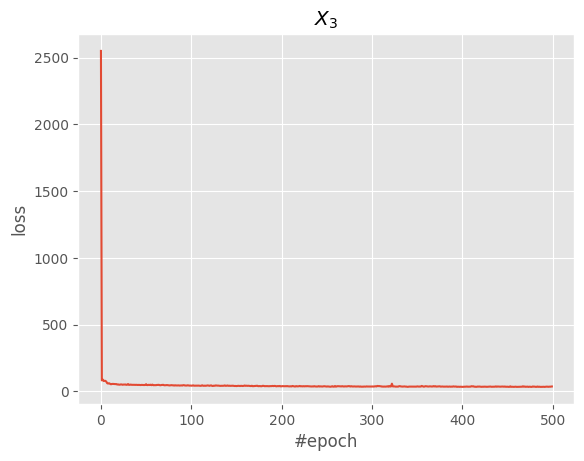

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss_x3))), epoch_loss_x3)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
# ax.set_yscale('log')
ax.set_title('$X_3$')
fig.show()

In [10]:
def normalize_vec(x):
  return (x - np.mean(x)) / np.std(x)

In [11]:
# define the Dec_i(Z_i, X_{pa_i})
def DEC_3(z3, x3_parents):
    x3_hat = np.zeros(T + 1)
    x3_hat[T] = z3
    for i in range(1, T + 1):
        t = T + 1 - i
        
        # change the network mode to evaluation
        net_x3.eval()
        # define the inputs
        input_1_x3_new = np.array([x3_hat[t]])
        input_2_1_x3_new = np.array([x3_parents[0]])
        input_2_2_x3_new = np.array([x3_parents[1]])
        input_3_x3_new = np.array([t])
        input_x3 = np.stack([input_1_x3_new, input_2_1_x3_new, input_2_2_x3_new, input_3_x3_new], axis=1)
        # convert the input to tensor
        input_x3_tensor = torch.from_numpy(input_x3).float()
        # make prediction
        with torch.no_grad():
            output_x3_tensor = net_x3(input_x3_tensor)
        # convert the output to numpy data
        output_x3 = output_x3_tensor.data.numpy()

        x3_hat[t - 1] = np.sqrt(alpha_t[t - 2] / alpha_t[t - 1]) * x3_hat[t] - output_x3[0][0] * (np.sqrt(alpha_t[t - 2] * (1 - alpha_t[t - 1]) / alpha_t[t - 1]) - np.sqrt(1 - alpha_t[t - 2]))
    return x3_hat[0]

In [12]:
# define the function to sample X_3 n times when we intervene to X_2 
def sample_X3(n_sampled, x2_intervention):
    # initialize the sample list by just zero vector 
    x3_DDIM_list = np.zeros(n_sampled)

    # iteratively sample 
    for i in range(n_sampled):
        # sample the optional noise Z_i
        z3 = np.random.normal(0, 1)
        # sample X_1 from the empirical distribution
        x1_sampled = random.choice(x1)
        # set X_2 to the intervened value
        x2_sampled = x2_intervention
        # concatenate the parents and nodes which satisfy the backdoor criterion
        x3_parents = np.array([x1_sampled, x2_sampled])
        # sample X_3 by using the decoder function
        x3_sampled = DEC_3(z3, x3_parents)
        # add the sampled value to the list
        x3_DDIM_list[i] = x3_sampled
    
    return x3_DDIM_list

In [13]:
# define the function to show the histogram of samples by DDIM and true target
def show_hist(x_sample, x_target, title_string):
  figure, axis = plt.subplots(1, 2, figsize=(14, 5))
    
  # unnormalized
  axis[0].hist(x_sample, 100, density = True, label = "sample")
  axis[0].hist(x_target, 100, density = True, alpha = 0.5, label = "target dist")
  axis[0].set_title("${}$ (before normalization)".format(title_string))
  axis[0].legend()
    
  # normalized
  axis[1].hist(normalize_vec(x_sample), 100, density = True, label = "sample")
  axis[1].hist(normalize_vec(x_target), 100, density = True, alpha = 0.5, label = "target dist")
  axis[1].set_title("${}$ (after normalization)".format(title_string))
  axis[1].legend()

  # Combine all the operations and display
  plt.show()

In [14]:
# sample from the target when we intervene by do(X2 = 0)
x3_do_0_DDIM = sample_X3(n_sampled, 0)

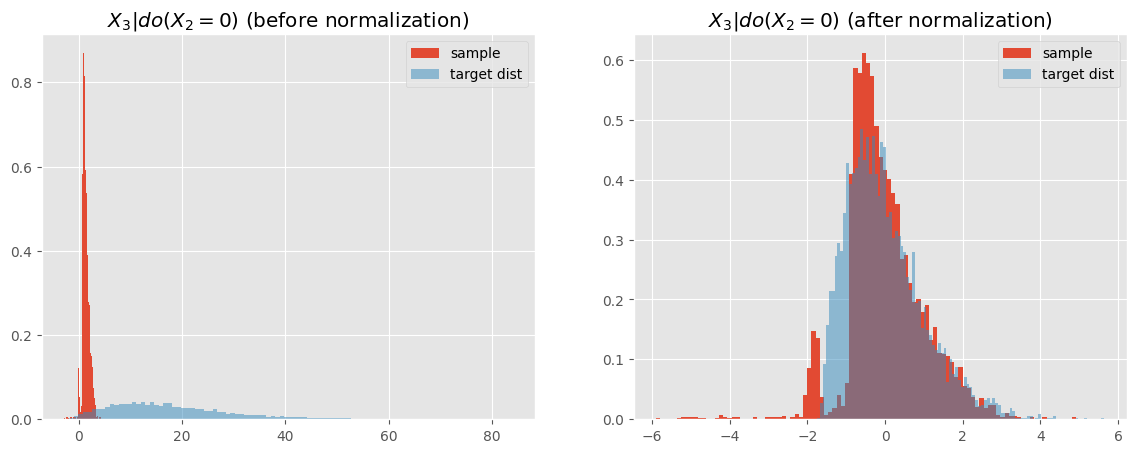

In [15]:
# plot the histograms of samples and target
show_hist(x3_do_0_DDIM, x3_do_0, "X_3|do(X_2 = 0)")

In [16]:
# sample from the target when we intervene by do(X2 = 1)
x3_do_1_DDIM = sample_X3(n_sampled, 1)

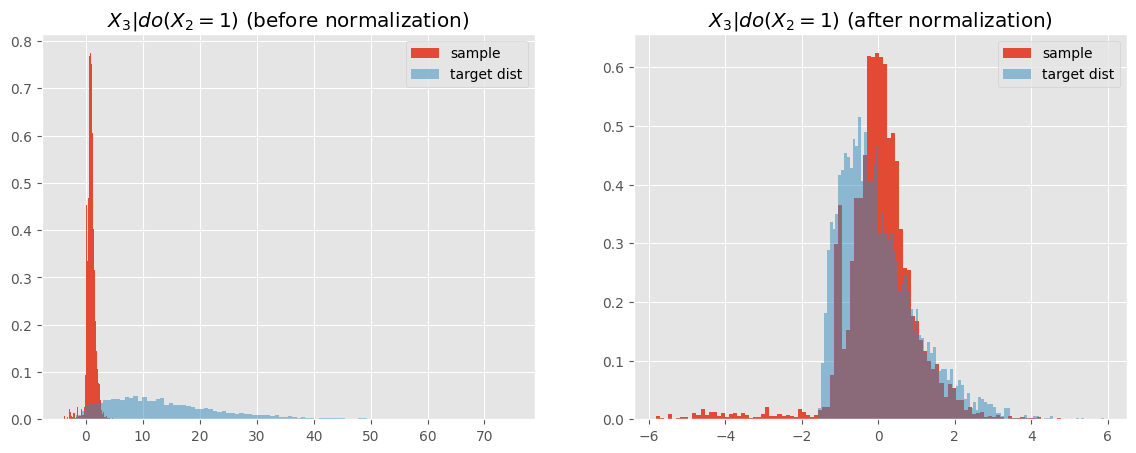

In [17]:
# plot the histograms of samples and target
show_hist(x3_do_1_DDIM, x3_do_1, "X_3|do(X_2 = 1)")

In [18]:
# sample from the target when we intervene by do(X2 = 5)
x3_do_5_DDIM = sample_X3(n_sampled, 5)

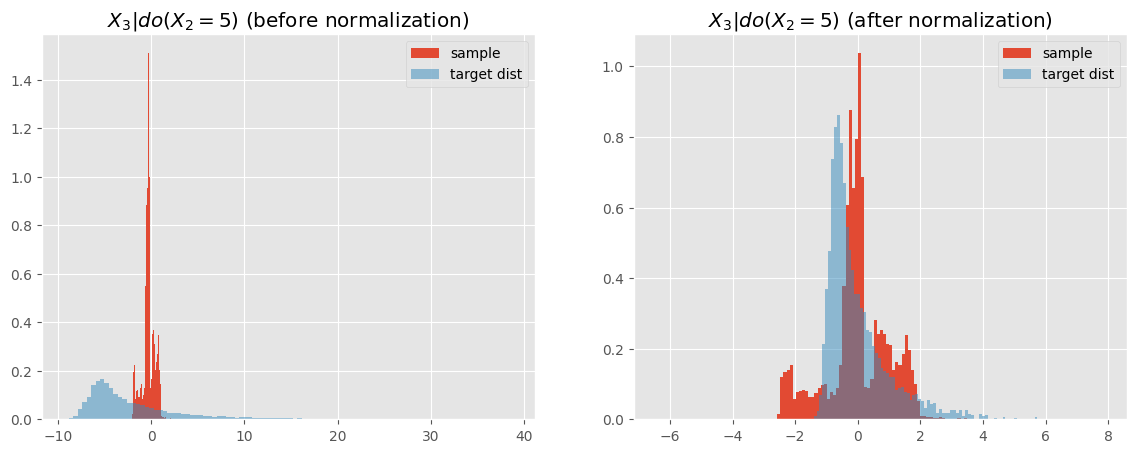

In [19]:
# plot the histograms of samples and target
show_hist(x3_do_5_DDIM, x3_do_5, "X_3|do(X_2 = 5)")

In [20]:
# sample from the target when we intervene by do(X2 = 10)
x3_do_10_DDIM = sample_X3(n_sampled, 10)

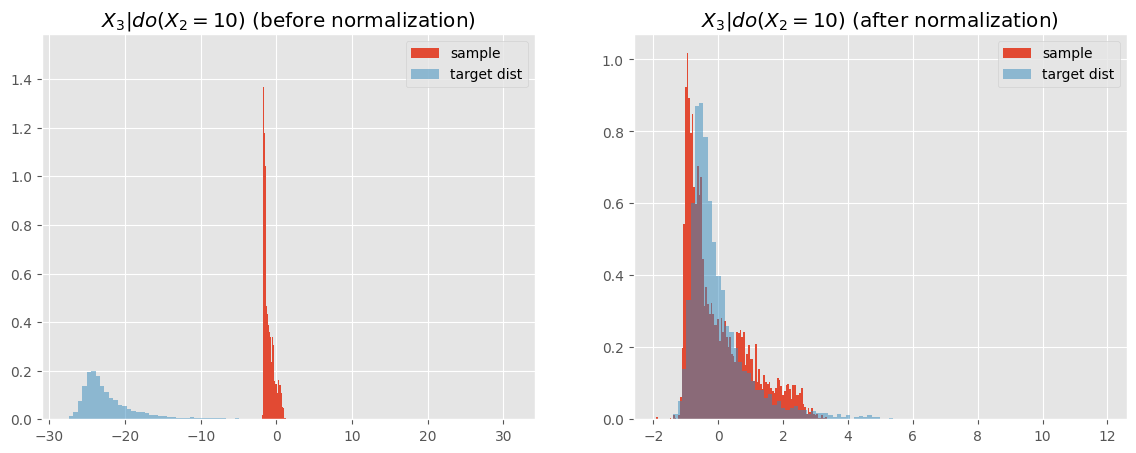

In [21]:
# plot the histograms of samples and target
show_hist(x3_do_10_DDIM, x3_do_10, "X_3|do(X_2 = 10)")

In [22]:
# define the function to sample X_3 n times when we do not intervene to X_2 
def sample_X3_observational(n_sampled):
    # initialize the sample list by just zero vector 
    x3_DDIM_list = np.zeros(n_sampled)

    # iteratively sample 
    for i in range(n_sampled):
        # sample the optional noise Z_i
        z3 = np.random.normal(0, 1)
        # sample X_1 from the empirical distribution
        x1_sampled = random.choice(x1)
        # sample X_2 from the empirical distribution
        x2_sampled = random.choice(x2)
        # concatenate the parents and nodes which satisfy the backdoor criterion
        x3_parents = np.array([x1_sampled, x2_sampled])
        # sample X_3 by using the decoder function
        x3_sampled = DEC_3(z3, x3_parents)
        # add the sampled value to the list
        x3_DDIM_list[i] = x3_sampled
    
    return x3_DDIM_list

In [23]:
# sample from the target when we do not intervene 
x3_DDIM_observational = sample_X3_observational(n_sampled)

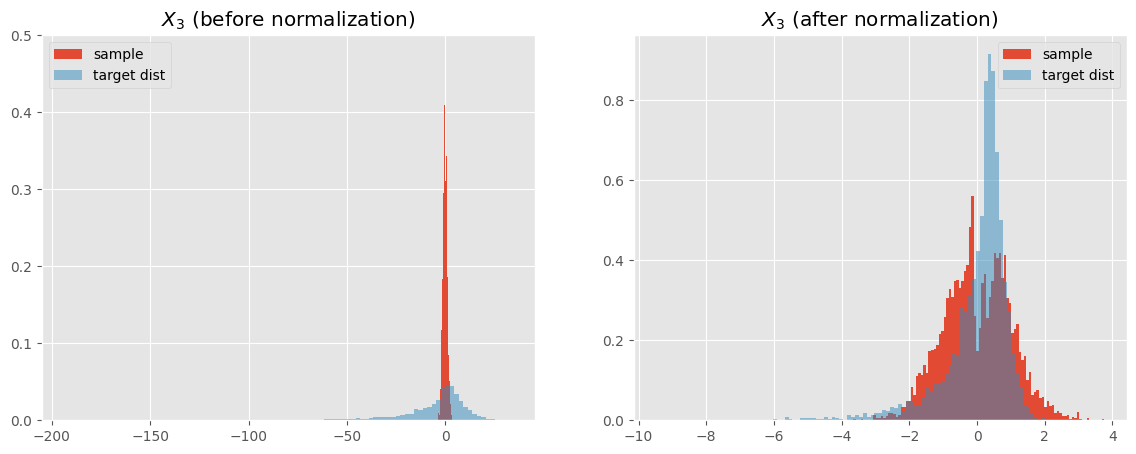

In [24]:
# plot the histograms of samples and target
show_hist(x3_DDIM_observational, x3, "X_3")

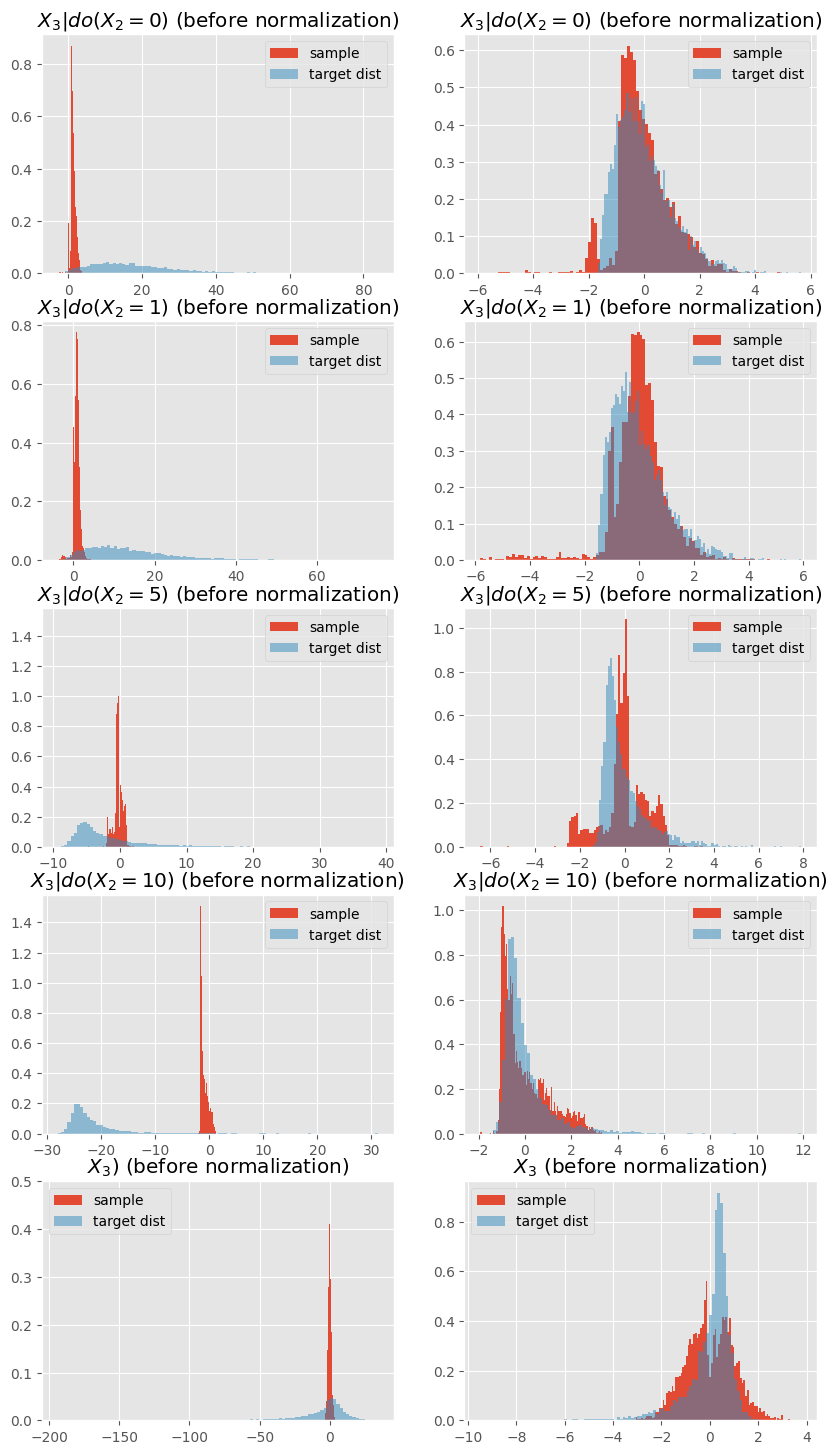

In [34]:
# show all the graphs do(X_2 = 0, 1, 5, 10) and observatinal queries
figure, axis = plt.subplots(5, 2, figsize=(10, 18))
  
# unnormalized do(X_2 = 0)
axis[0][0].hist(x3_do_0_DDIM, 100, density = True, label = "sample")
axis[0][0].hist(x3_do_0, 100, density = True, alpha = 0.5, label = "target dist")
axis[0][0].set_title("$X_3|do(X_2 = 0)$ (before normalization)")
axis[0][0].legend()
  
# normalized do(X_2 = 0)
axis[0][1].hist(normalize_vec(x3_do_0_DDIM), 100, density = True, label = "sample")
axis[0][1].hist(normalize_vec(x3_do_0), 100, density = True, alpha = 0.5, label = "target dist")
axis[0][1].set_title("$X_3|do(X_2 = 0)$ (before normalization)")
axis[0][1].legend()

# unnormalized do(X_2 = 1)
axis[1][0].hist(x3_do_1_DDIM, 100, density = True, label = "sample")
axis[1][0].hist(x3_do_1, 100, density = True, alpha = 0.5, label = "target dist")
axis[1][0].set_title("$X_3|do(X_2 = 1)$ (before normalization)")
axis[1][0].legend()
  
# normalized do(X_2 = 1)
axis[1][1].hist(normalize_vec(x3_do_1_DDIM), 100, density = True, label = "sample")
axis[1][1].hist(normalize_vec(x3_do_1), 100, density = True, alpha = 0.5, label = "target dist")
axis[1][1].set_title("$X_3|do(X_2 = 1)$ (before normalization)")
axis[1][1].legend()

# unnormalized do(X_2 = 5)
axis[2][0].hist(x3_do_5_DDIM, 100, density = True, label = "sample")
axis[2][0].hist(x3_do_5, 100, density = True, alpha = 0.5, label = "target dist")
axis[2][0].set_title("$X_3|do(X_2 = 5)$ (before normalization)")
axis[2][0].legend()
  
# normalized do(X_2 = 5)
axis[2][1].hist(normalize_vec(x3_do_5_DDIM), 100, density = True, label = "sample")
axis[2][1].hist(normalize_vec(x3_do_5), 100, density = True, alpha = 0.5, label = "target dist")
axis[2][1].set_title("$X_3|do(X_2 = 5)$ (before normalization)")
axis[2][1].legend()


# unnormalized do(X_2 = 10)
axis[3][0].hist(x3_do_10_DDIM, 100, density = True, label = "sample")
axis[3][0].hist(x3_do_10, 100, density = True, alpha = 0.5, label = "target dist")
axis[3][0].set_title("$X_3|do(X_2 = 10)$ (before normalization)")
axis[3][0].legend()
  
# normalized do(X_2 = 10)
axis[3][1].hist(normalize_vec(x3_do_10_DDIM), 100, density = True, label = "sample")
axis[3][1].hist(normalize_vec(x3_do_10), 100, density = True, alpha = 0.5, label = "target dist")
axis[3][1].set_title("$X_3|do(X_2 = 10)$ (before normalization)")
axis[3][1].legend()

# unnormalized observational
axis[4][0].hist(x3_DDIM_observational, 100, density = True, label = "sample")
axis[4][0].hist(x3, 100, density = True, alpha = 0.5, label = "target dist")
axis[4][0].set_title("$X_3)$ (before normalization)")
axis[4][0].legend()
  
# normalized observational
axis[4][1].hist(normalize_vec(x3_DDIM_observational), 100, density = True, label = "sample")
axis[4][1].hist(normalize_vec(x3), 100, density = True, alpha = 0.5, label = "target dist")
axis[4][1].set_title("$X_3$ (before normalization)")
axis[4][1].legend()


# Combine all the operations and display
plt.show()